In [128]:
import pandas as pd
from idaes.core.solvers import get_solver
from pyomo.environ import ConcreteModel, RangeSet, Var, log10, minimize


In [129]:
df = pd.read_excel("data for parmest.xlsx", sheet_name = "Fe only")
# df = df[df['ascorbic (g/L)'] != 0]
index = df.shape[0]
idx_list = RangeSet(0,index-1)
print(df)

    ascorbic (g/L)        pH  dosage          E           D      logD   w
0             1.50  0.759084     5.0   3.354839    0.034713 -1.459508   1
1             1.50  0.922433     5.0   3.870968    0.040268 -1.395035   1
2             1.50  1.243918     5.0   6.967742    0.074896 -1.125542   1
3             1.50  1.454186     5.0  17.548387    0.212833 -0.671962   1
4             1.50  1.598420     5.0  25.290323    0.338515 -0.470422   1
5             1.50  1.812164     5.0  32.774194    0.487524 -0.312004   1
6             1.25  0.759084     5.0   6.967742    0.074896 -1.125542   1
7             1.25  0.898104     5.0   8.000000    0.086957 -1.060698   1
8             1.25  1.235229     5.0  20.387097    0.256078 -0.591628   1
9             1.25  1.369036     5.0  30.451613    0.437848 -0.358677   1
10            1.25  1.589731     5.0  39.483871    0.652452 -0.185451   1
11            1.25  1.765245     5.0  45.677419    0.840855 -0.075279   1
12            1.00  0.750395     5.0  

In [130]:
dosage_list = df['dosage'].unique()
dosage_list

array([5. , 1. , 2. , 3. , 4. , 3.3])

In [131]:
m = ConcreteModel()

m.pH = Var(idx_list)
m.dosage = Var(idx_list)
m.logD_exp = Var(idx_list)
m.logD_model = Var(idx_list)
m.ascorbic = Var(idx_list)

for i in idx_list:
    m.pH[i].fix(df['pH'][i])
    m.dosage[i].fix(df['dosage'][i])
    m.logD_exp[i].fix(df['logD'][i])
    m.ascorbic[i].fix(df['ascorbic (g/L)'][i])

ascorbic_list = df['ascorbic (g/L)'].unique()
dosage_list = df['dosage'].unique()

# variable_list = [1,2]

m.a = Var(ascorbic_list, initialize=0.1, bounds=(-10, 10))
m.b = Var(ascorbic_list, initialize=0.1, bounds=(0, 10))
m.c = Var(ascorbic_list, initialize=0.1, bounds=(-10, 10))
m.d = Var(initialize=0.1, bounds=(0, 10))


@m.Constraint(idx_list)
def logD_model_rule(m,i):
    asc_index = df['ascorbic (g/L)'][i]
    dosage_idx = df['dosage'][i]
    return m.logD_model[i] == (m.a[asc_index]+m.b[asc_index]*m.dosage[i])*m.pH[i] + (m.c[asc_index]+m.d*log10(m.dosage[i]))
@m.Expression()
def SSE(m):
    return sum(((m.logD_exp[i] - m.logD_model[i])**2)*df['w'][i] for i in idx_list)

@m.Objective(sense=minimize)
def objective_rule(m):
    return m.SSE

solver=get_solver('ipopt_v2')
solver.solve(m, tee=True)


Ipopt 3.13.2: linear_solver="ma57"
max_iter=200
nlp_scaling_method="gradient-based"
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collect

{'Problem': [{'Lower bound': None, 'Upper bound': 12.619384980654976, 'Number of objectives': 1, 'Number of constraints': nan, 'Number of variables': nan, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.convergenceCriteriaSatisfied'}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [132]:
m.logD_model_rule.pprint()

logD_model_rule : Size=55, Index=[0:54], Active=True
    Key : Lower : Body                                                                                     : Upper : Active
      0 :   0.0 :        logD_model[0] - (c[1.5] + d*log10(dosage[0]) + (a[1.5] + b[1.5]*dosage[0])*pH[0]) :   0.0 :   True
      1 :   0.0 :        logD_model[1] - (c[1.5] + d*log10(dosage[1]) + (a[1.5] + b[1.5]*dosage[1])*pH[1]) :   0.0 :   True
      2 :   0.0 :        logD_model[2] - (c[1.5] + d*log10(dosage[2]) + (a[1.5] + b[1.5]*dosage[2])*pH[2]) :   0.0 :   True
      3 :   0.0 :        logD_model[3] - (c[1.5] + d*log10(dosage[3]) + (a[1.5] + b[1.5]*dosage[3])*pH[3]) :   0.0 :   True
      4 :   0.0 :        logD_model[4] - (c[1.5] + d*log10(dosage[4]) + (a[1.5] + b[1.5]*dosage[4])*pH[4]) :   0.0 :   True
      5 :   0.0 :        logD_model[5] - (c[1.5] + d*log10(dosage[5]) + (a[1.5] + b[1.5]*dosage[5])*pH[5]) :   0.0 :   True
      6 :   0.0 :     logD_model[6] - (c[1.25] + d*log10(dosage[6]) + (a[1.25] 

In [133]:
m.a.pprint()
m.b.pprint()
m.c.pprint()
m.d.pprint()

a : Size=7, Index={0.75, 1.5, 0.5, 1.25, 1.0, 0.25, 0.0}
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
     0.0 :   -10 :   2.371092094329287 :    10 : False : False :  Reals
    0.25 :   -10 :  -2.650664031365256 :    10 : False : False :  Reals
     0.5 :   -10 : -2.7657643565779066 :    10 : False : False :  Reals
    0.75 :   -10 : -2.8719811322837696 :    10 : False : False :  Reals
     1.0 :   -10 :  -2.831546463836395 :    10 : False : False :  Reals
    1.25 :   -10 : -2.7465591057121497 :    10 : False : False :  Reals
     1.5 :   -10 : -2.7240424868654003 :    10 : False : False :  Reals
b : Size=7, Index={0.75, 1.5, 0.5, 1.25, 1.0, 0.25, 0.0}
    Key  : Lower : Value                  : Upper : Fixed : Stale : Domain
     0.0 :     0 : 1.8399117561054804e-08 :    10 : False : False :  Reals
    0.25 :     0 :      0.758116649482667 :    10 : False : False :  Reals
     0.5 :     0 :     0.7548928742555795 :    10 : False : False :  Reals
    0.75 :

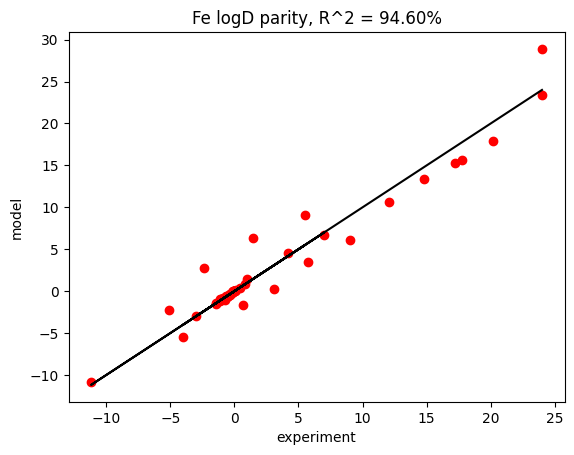

In [137]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error


plt.figure()
x = [m.logD_exp[i].value*df['w'][i] for i in idx_list]
y = [m.logD_model[i].value*df['w'][i] for i in idx_list]
x_ideal = [m.logD_exp[i].value*df['w'][i] for i in idx_list]
plt.plot(x_ideal, x_ideal, label='y=x (ideal)', linestyle='-', color='black')

for i in idx_list:
    plt.scatter(x[i], y[i], color='red', label='5% DEHPA 10% TBP')
plt.xlabel('experiment')
plt.ylabel('model')
plt.title(f"Fe logD parity, R^2 = {r2_score(x, y)*100:.2f}%")

plt.show()

In [46]:
ascorbic_list =df['ascorbic (g/L)'].unique()

In [8]:
ascorbic_list

array([1.5 , 1.25, 1.  , 0.75, 0.5 , 0.25, 0.  ])

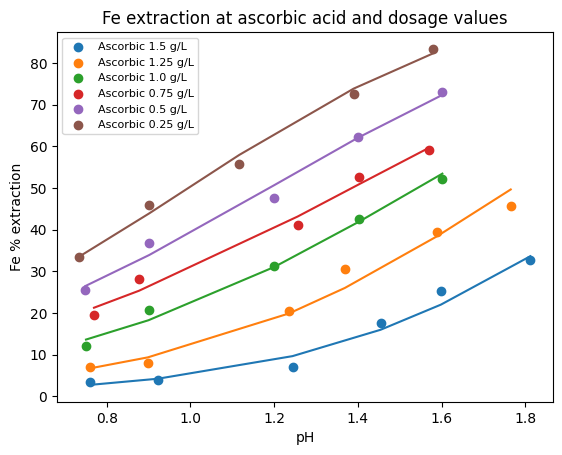

In [138]:
plt.figure()
for idx_s, s in enumerate(ascorbic_list):
    if s!=0:
        pH_list = df['pH'][(df['ascorbic (g/L)'] == s)].values
        dosage = df['dosage'][(df['ascorbic (g/L)'] == s)].values
        logD_exp_list = df['logD'][(df['ascorbic (g/L)'] == s)].values
        logD_model_list = [(m.a[s]()+m.b[s]()*dosage[0])*pH + (m.c[s]()+m.d()*log10(dosage[0])) for pH in pH_list]
        label = f'Ascorbic {s} g/L'
        plt.scatter(pH_list, [100*10**logD_exp/(1+10**logD_exp) for logD_exp in logD_exp_list], label=label)
        plt.plot(pH_list, [100*10**logD_model/(1+10**logD_model) for logD_model in logD_model_list])
plt.xlabel('pH')
plt.ylabel('Fe % extraction')
plt.title('Fe extraction at ascorbic acid and dosage values')
plt.legend(fontsize=8)

In [139]:
df_0 = df[(df['ascorbic (g/L)'] == 0) & (df['dosage'] != 3.3) & (df['w'] != 0)]
df_0

,ascorbic (g/L),pH,dosage,E,D,logD,w
32,0.0,0.5,1.0,8.43,0.276182,-0.558804,20
33,0.0,0.5,2.0,15.59,0.554081,-0.256427,20
34,0.0,0.5,3.0,20.18,0.758457,-0.120069,20
35,0.0,0.5,4.0,28.24,1.180602,0.072104,20
36,0.0,0.5,5.0,38.65,1.889976,0.276456,20


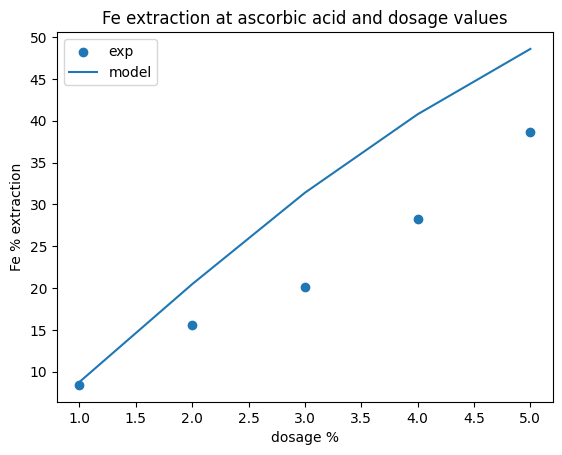

In [140]:
dosage = df_0['dosage'].values
logD_exp_list = df_0['logD'].values
logD_model_list = [(m.a[0]()+m.b[0]()*d)*0.5 + (m.c[0]()+m.d()*log10(d)) for d in dosage]
plt.scatter(dosage, [100*10**logD_exp/(3+10**logD_exp) for logD_exp in logD_exp_list], label=label)
plt.plot(dosage, [100*10**logD_model/(3+10**logD_model) for logD_model in logD_model_list])
plt.xlabel('dosage %')
plt.ylabel('Fe % extraction')
plt.title('Fe extraction at ascorbic acid and dosage values')
plt.legend(['exp','model'])

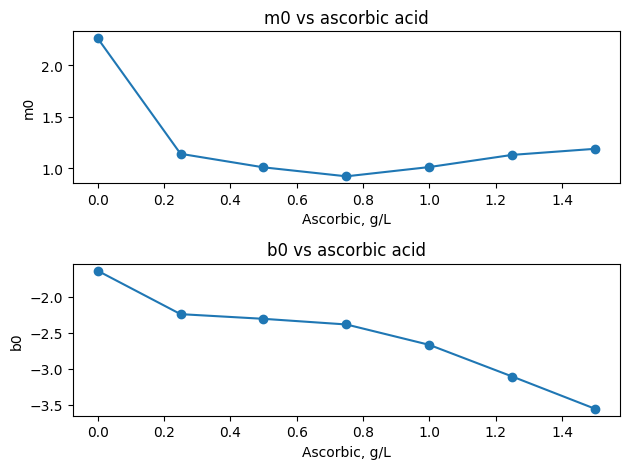

In [81]:
from numpy import sort


fig, ax = plt.subplots(2)

ax[0].plot(sort(ascorbic_list), [m.a[s]() for s in sort(ascorbic_list)], marker='o')
ax[0].set_xlabel('Ascorbic, g/L')
ax[0].set_ylabel('m0')
ax[0].set_title('m0 vs ascorbic acid')

ax[1].plot(sort(ascorbic_list), [m.c[s]() for s in sort(ascorbic_list)], marker='o')
ax[1].set_xlabel('Ascorbic, g/L')
ax[1].set_ylabel('b0')
ax[1].set_title('b0 vs ascorbic acid')

plt.tight_layout()

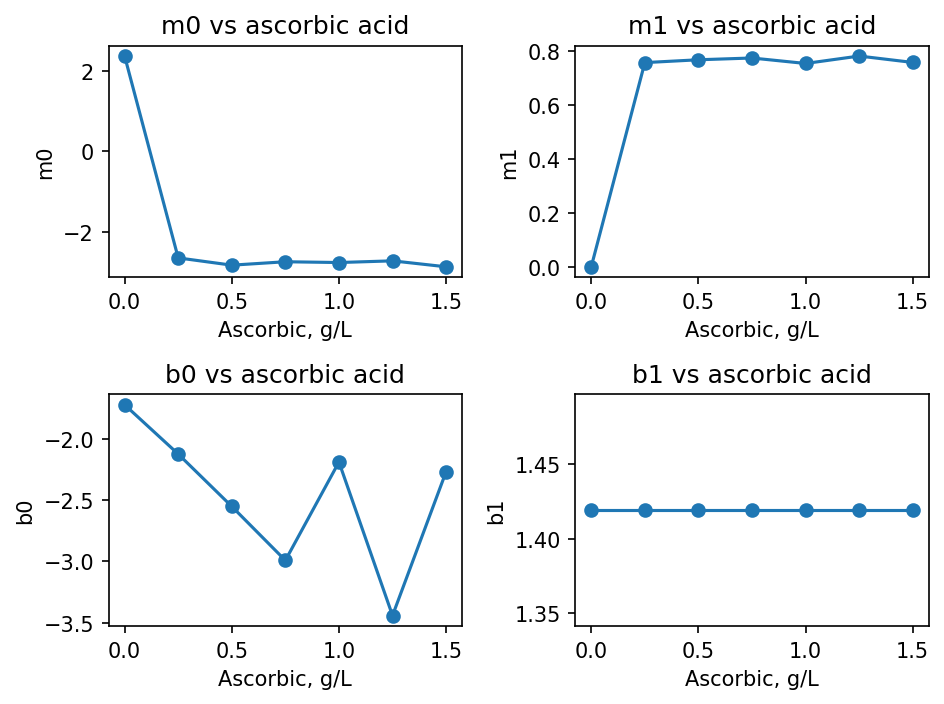

In [141]:
from numpy import ones


fig, ax = plt.subplots(2,2,dpi=150)

ax[0,0].plot(ascorbic_list, m.a[:](), marker='o')
ax[0,0].set_xlabel('Ascorbic, g/L')
ax[0,0].set_ylabel('m0')
ax[0,0].set_title('m0 vs ascorbic acid')

ax[0,1].plot(ascorbic_list, m.b[:](), marker='o')
ax[0,1].set_xlabel('Ascorbic, g/L')
ax[0,1].set_ylabel('m1')
ax[0,1].set_title('m1 vs ascorbic acid')

ax[1,0].plot(ascorbic_list, m.c[:](), marker='o')
ax[1,0].set_xlabel('Ascorbic, g/L')
ax[1,0].set_ylabel('b0')
ax[1,0].set_title('b0 vs ascorbic acid')

ax[1,1].plot(ascorbic_list, m.d()*ones(len(ascorbic_list)), marker='o')
ax[1,1].set_xlabel('Ascorbic, g/L')
ax[1,1].set_ylabel('b1')
ax[1,1].set_title('b1 vs ascorbic acid')

plt.tight_layout()

In [14]:
from idaes.core.util.model_statistics import degrees_of_freedom as dof
print(dof(m))


28
